In [3]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from functools import partial
from pyscf import gto, scf
from qmc.extract import pyscf_parameter
from qmc.mc import np_initial_guess
from qmc.orbitals import aos, mos, orbital_from_pyscf

In [4]:
mol = gto.Mole()

mol.atom = '''
O 0.000000 0.000000 0.117790
H 0.000000 0.755453 -0.471161
H 0.000000 -0.755453 -0.471161
'''
mol.basis = 'sto-3g'

mol.build()
mf = scf.RHF(mol)
mf.kernel()

converged SCF energy = -74.963146775618


np.float64(-74.96314677561796)

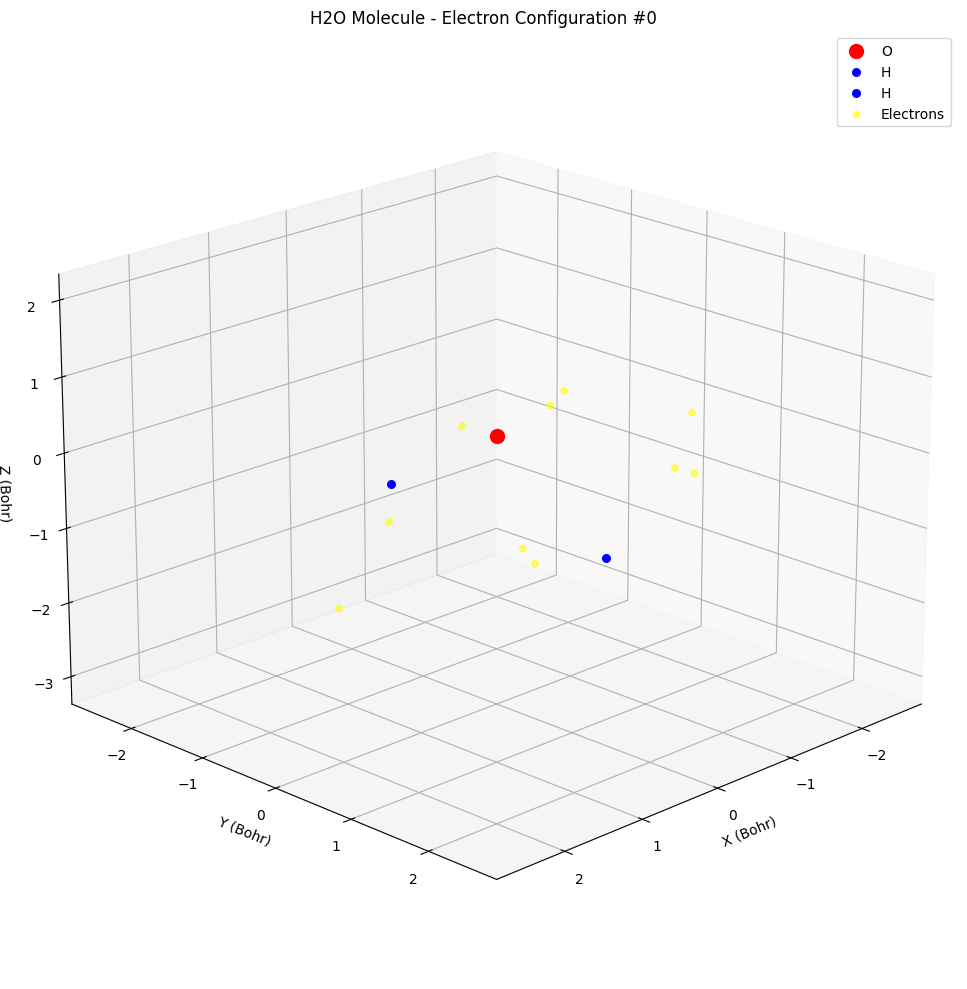

In [23]:
import pyqmc.api as pyq
from pyqmc.api import Slater
np.random.seed(42)  # 시드값 42로 고정

coords = np_initial_guess(mol, 1000)
configs = coords

def visualize_h2o_config(mol, configs, config_idx=0):
 
    atoms = mol.atom_coords()
    atom_symbols = [atom[0] for atom in mol._atom]
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    colors = {'O': 'red', 'H': 'blue'}
    sizes = {'O': 100, 'H': 30}
    
    for atom, symbol in zip(atoms, atom_symbols):
        ax.scatter(*atom, c=colors[symbol], s=sizes[symbol], label=symbol)
    
    electron_positions = configs[config_idx]  # shape: (nelec, 3)
    ax.scatter(electron_positions[:, 0], 
              electron_positions[:, 1], 
              electron_positions[:, 2],
              c='yellow', s=20, alpha=0.6, label='Electrons')
    
    ax.set_xlabel('X (Bohr)')
    ax.set_ylabel('Y (Bohr)')
    ax.set_zlabel('Z (Bohr)')
    ax.legend()
    
    ax.view_init(elev=20, azim=45)
    
    max_range = max(
        np.ptp(atoms[:, 0]),
        np.ptp(atoms[:, 1]),
        np.ptp(atoms[:, 2])
    ) * 2
    
    ax.set_xlim(atoms[:, 0].mean() - max_range/2, atoms[:, 0].mean() + max_range/2)
    ax.set_ylim(atoms[:, 1].mean() - max_range/2, atoms[:, 1].mean() + max_range/2)
    ax.set_zlim(atoms[:, 2].mean() - max_range/2, atoms[:, 2].mean() + max_range/2)
    
    plt.title(f'H2O Molecule - Electron Configuration #{config_idx}')
    plt.tight_layout()
    plt.show()

visualize_h2o_config(mol, configs)

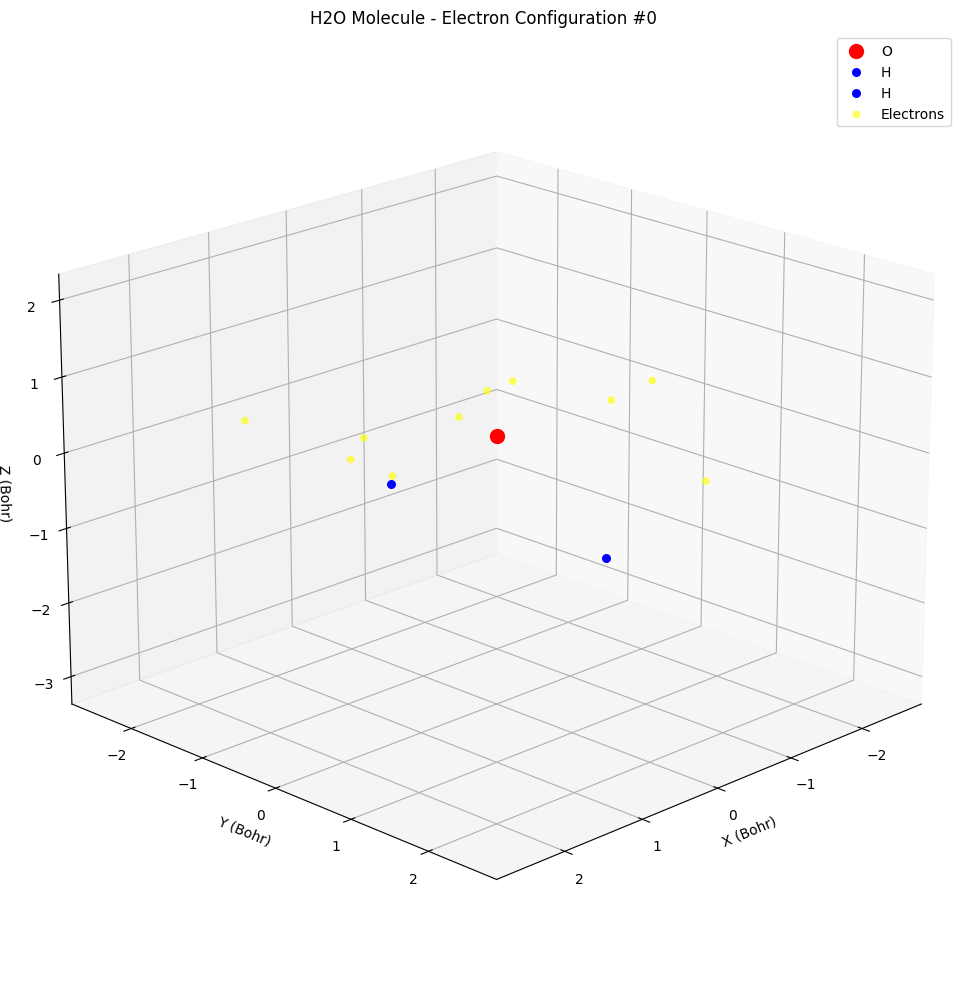

In [28]:
import pyqmc.api as pyq
from pyqmc.api import Slater
np.random.seed(42)  # 시드값 42로 고정

coords = pyq.initial_guess(mol, 1000)
coords = coords.configs

def visualize_h2o_config(mol, configs, config_idx=0):
 
    atoms = mol.atom_coords()
    atom_symbols = [atom[0] for atom in mol._atom]
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    colors = {'O': 'red', 'H': 'blue'}
    sizes = {'O': 100, 'H': 30}
    
    for atom, symbol in zip(atoms, atom_symbols):
        ax.scatter(*atom, c=colors[symbol], s=sizes[symbol], label=symbol)
    
    electron_positions = configs[config_idx]  # shape: (nelec, 3)
    ax.scatter(electron_positions[:, 0], 
              electron_positions[:, 1], 
              electron_positions[:, 2],
              c='yellow', s=20, alpha=0.6, label='Electrons')
    
    ax.set_xlabel('X (Bohr)')
    ax.set_ylabel('Y (Bohr)')
    ax.set_zlabel('Z (Bohr)')
    ax.legend()
    
    ax.view_init(elev=20, azim=45)
    
    max_range = max(
        np.ptp(atoms[:, 0]),
        np.ptp(atoms[:, 1]),
        np.ptp(atoms[:, 2])
    ) * 2
    
    ax.set_xlim(atoms[:, 0].mean() - max_range/2, atoms[:, 0].mean() + max_range/2)
    ax.set_ylim(atoms[:, 1].mean() - max_range/2, atoms[:, 1].mean() + max_range/2)
    ax.set_zlim(atoms[:, 2].mean() - max_range/2, atoms[:, 2].mean() + max_range/2)
    
    plt.title(f'H2O Molecule - Electron Configuration #{config_idx}')
    plt.tight_layout()
    plt.show()

visualize_h2o_config(mol, coords)

In [6]:
coeff = mf.mo_coeff
configs = np_initial_guess(mol, 1000)
nconf, nelec, ndim = configs.shape
max_orb, mo_coeff, detcoeff, occup, detmap, _nelec = orbital_from_pyscf(mol, mf)

print(f"The electorn cofiguration is \t{nconf}, {nelec}, {ndim}")
print("----------------------------------------------------------------------------------------------------")
print(f"determinant coefficent is {detcoeff}")
print("----------------------------------------------------------------------------------------------------")
print(f"ocupied orbitals is {occup}")
print("----------------------------------------------------------------------------------------------------")
print(f"determinant map is {detmap}")

The electorn cofiguration is 	1000, 10, 3
----------------------------------------------------------------------------------------------------
determinant coefficent is [1.]
----------------------------------------------------------------------------------------------------
ocupied orbitals is [[Array([0, 1, 2, 3, 4], dtype=int32)], [Array([0, 1, 2, 3, 4], dtype=int32)]]
----------------------------------------------------------------------------------------------------
determinant map is [[0]
 [0]]


In [20]:
mo_coeff[0].shape

(7, 5)

In [15]:
nconf, nelec_tot, ndim = configs.shape
gtoval = "GTOval_sph"
atomic_orbital = aos(mol, gtoval, configs)
print(atomic_orbital.shape)
aovals = atomic_orbital.reshape(-1, nconf, nelec_tot, atomic_orbital.shape[-1])
print(aovals.shape)
nelec = (nelec_tot//2, nelec_tot//2)
s = 0  # up 스
begin = nelec[0] * s
end = nelec[0] + nelec[1] * s
mo = mos(aovals[:, :, begin:end, :], mo_coeff[0])
print(aovals[:, :, begin:end, :].shape)
print(mo.shape)
print(occup)
mo_vals = jnp.swapaxes(mo[:, :, occup[s]], 1, 2)
signs, logdets = jnp.linalg.slogdet(mo_vals)
print(logdets)

(1, 10000, 7)
(1, 1000, 10, 7)
(1, 1000, 5, 7)
(1000, 5, 5)
[[Array([0, 1, 2, 3, 4], dtype=int32)], [Array([0, 1, 2, 3, 4], dtype=int32)]]
[[ -8.885452 ]
 [-18.090946 ]
 [-12.573296 ]
 [-15.170002 ]
 [-18.6203   ]
 [-15.520672 ]
 [-17.736895 ]
 [-11.302777 ]
 [-13.259426 ]
 [ -9.554584 ]
 [-13.208263 ]
 [ -6.709147 ]
 [-13.451359 ]
 [-18.782026 ]
 [-15.197124 ]
 [-13.193479 ]
 [-13.840639 ]
 [-18.141603 ]
 [ -9.236681 ]
 [-13.526371 ]
 [-19.382381 ]
 [-12.943644 ]
 [-16.302113 ]
 [ -7.512485 ]
 [-13.452934 ]
 [-16.126123 ]
 [ -6.6165676]
 [ -9.9765415]
 [ -9.7296505]
 [ -8.331554 ]
 [-15.953487 ]
 [-14.989275 ]
 [-13.853346 ]
 [-20.455494 ]
 [-15.117029 ]
 [-14.371751 ]
 [-21.029575 ]
 [-15.426286 ]
 [-10.552155 ]
 [-13.821407 ]
 [-10.629663 ]
 [-17.317429 ]
 [-13.5889225]
 [-16.144585 ]
 [-10.193327 ]
 [-13.50906  ]
 [-17.00568  ]
 [-16.934084 ]
 [-12.588411 ]
 [-11.993147 ]
 [ -9.614367 ]
 [ -5.976717 ]
 [-12.820589 ]
 [-14.347537 ]
 [ -7.23407  ]
 [-11.388277 ]
 [-10.063984 ]
 [-11.

In [32]:
occup

[[Array([0, 1, 2, 3, 4], dtype=int32)], [Array([0, 1, 2, 3, 4], dtype=int32)]]

In [50]:
coeff = mf.mo_coeff
configs = np_initial_guess(mol, 1000)
nconf, nelec, ndim = configs.shape
detcoeff, occup, detmap = orbital_from_pyscf(mol, mf)
max_orb = jnp.max(
    jax.vmap(lambda det: jax.vmap(lambda s: jnp.where(s.size > 0, jnp.max(s) + 1, 0))(det))(
        jnp.array([det for _, det in determinants])
    ), 
    axis=0
)
# mo_coeff = [coeff[spin][:, 0 : max_orb[spin]] for spin in [0, 1]]

print(f"The electorn cofiguration is \t{nconf}, {nelec}, {ndim}")
print("----------------------------------------------------------------------------------------------------")
print(f"determinant coefficent is {detcoeff}")
print("----------------------------------------------------------------------------------------------------")
print(f"ocupied orbitals is {occup}")
print("----------------------------------------------------------------------------------------------------")
print(f"determinant map is {detmap}")

NameError: name 'determinants' is not defined

In [14]:
detcoeff, occup, detmap = orbital_from_pyscf(mol, mf)
eval_str = "GTOval"
atomic_orbital = aos(mol, eval_str, configs)
aovals = atomic_orbital.reshape(-1, nconf, nelec, atomic_orbital.shape[-1])

In [ ]:
mo_coeff = mf.mo_coeff
mo_coeff = 

In [15]:
atomic_orbital.shape

(1, 10000, 7)

In [7]:
from functools import partial
import jax
import jax.numpy as jnp

@partial(jax.jit, static_argnums=(2, 3))
def recompute(configs, gtoval, det_occup):
    nconf, nelec, ndim = configs.shape
    atomic_orbital = aos(gtoval, configs)
    aovals = atomic_orbital.reshape(-1, nconf, nelec_tot, atomic_orbital.shape[-1])
    
    def compute_spin_component(s, aovals, nelec, det_occup):
        begin = nelec[0] * s
        end = nelec[0] + nelec[1] * s
        mo = mos(aovals[:, :, begin:end, :], s)
        mo_vals = jnp.swapaxes(mo[:, :, det_occup[s]], 1, 2)
        
        signs, logdets = jnp.linalg.slogdet(mo_vals)
        inverse = jax.lax.cond(
            jnp.all(jnp.isfinite(logdets)),
            lambda x: jax.vmap(jnp.linalg.inv)(x),
            lambda x: jnp.zeros_like(x),
            mo_vals
        )
        
        return signs, logdets, inverse
    
    up_results = compute_spin_component(0, aovals, nelec, det_occup)
    dn_results = compute_spin_component(1, aovals, nelec, det_occup)
    
    return (up_results, dn_results)

ValueError: Jitted function has static_argnums=(2, 3), but only accepts 3 positional arguments.

In [46]:
from functools import partial
import jax
import jax.numpy as jnp

@partial(jax.jit, static_argnums=(2,))
def recompute(configs, gtoval, det_occup):
    nconf, nelec_tot, ndim = configs.shape
    atomic_orbital = aos_fn(gtoval, configs)
    aovals = atomic_orbital.reshape(-1, nconf, nelec_tot, atomic_orbital.shape[-1])
    
    nelec = (nelec_tot//2, nelec_tot//2)
    
    def compute_spin_component(s, aovals, nelec, det_occup):
        begin = nelec[0] * s
        end = nelec[0] + nelec[1] * s
        mo = mos_fn(aovals[:, :, begin:end, :], s)
        mo_vals = jnp.swapaxes(mo[:, :, det_occup[s]], 1, 2)
        
        signs, logdets = jnp.linalg.slogdet(mo_vals)
        inverse = jax.lax.cond(
            jnp.all(jnp.isfinite(logdets)),
            lambda x: jax.vmap(jnp.linalg.inv)(x),
            lambda x: jnp.zeros_like(x),
            mo_vals
        )
        
        return signs, logdets, inverse
    
    up_results = compute_spin_component(0, aovals, nelec, det_occup)
    dn_results = compute_spin_component(1, aovals, nelec, det_occup)
    
    return (up_results, dn_results)

results = recompute(configs, "GTOval_sph", occup)

ValueError: Non-hashable static arguments are not supported, as this can lead to unexpected cache-misses. Static argument (index 2) of type <class 'list'> for function recompute is non-hashable.

In [7]:
@partial(jax.jit, static_argnums=(2,))
def recompute(configs, gtoval, det_occup):
    # det_occup을 tuple로 변환 (list는 unhashable)
    if isinstance(det_occup, list):
        det_occup = tuple(det_occup) if isinstance(det_occup[0], (list, tuple)) else (tuple(det_occup[0]), tuple(det_occup[1]))
    
    nconf, nelec_tot, ndim = configs.shape
    atomic_orbital = aos(gtoval, configs)
    aovals = atomic_orbital.reshape(-1, nconf, nelec_tot, atomic_orbital.shape[-1])
    
    nelec = (nelec_tot//2, nelec_tot//2)
    
    def compute_spin_component(s, aovals, nelec, det_occup):
        begin = nelec[0] * s
        end = nelec[0] + nelec[1] * s
        mo = mos(aovals[:, :, begin:end, :], s)
        mo_vals = jnp.swapaxes(mo[:, :, det_occup[s]], 1, 2)
        
        signs, logdets = jnp.linalg.slogdet(mo_vals)
        inverse = jax.lax.cond(
            jnp.all(jnp.isfinite(logdets)),
            lambda x: jax.vmap(jnp.linalg.inv)(x),
            lambda x: jnp.zeros_like(x),
            mo_vals
        )
        
        return signs, logdets, inverse
    
    up_results = compute_spin_component(0, aovals, nelec, det_occup)
    dn_results = compute_spin_component(1, aovals, nelec, det_occup)
    
    return (up_results, dn_results)

# 사용할 때
# occup을 tuple로 변환하여 전달

def convert_to_hashable(occup):
    # JAX Array를 일반 tuple로 변환
    up_orbs = tuple(map(int, occup[0][0]))
    dn_orbs = tuple(map(int, occup[1][0]))
    return (up_orbs, dn_orbs)

# 사용할 때
hashable_occup = convert_to_hashable(occup)
results = recompute(configs, "GTOval_sph", hashable_occup)

TypeError: Argument 'GTOval_sph' of type <class 'str'> is not a valid JAX type

In [51]:
from functools import partial
import jax
import jax.numpy as jnp

gtoval = "GTOval_sph"
atomic_orbital = aos(mol, gtoval, configs)

@partial(jax.jit, static_argnums=(2,))  # det_occup만 static으로 지정
def recompute(configs, atomic_orbital, det_occup):
    nconf, nelec_tot, ndim = configs.shape
    aovals = atomic_orbital.reshape(-1, nconf, nelec_tot, atomic_orbital.shape[-1])
    
    nelec = (nelec_tot//2, nelec_tot//2)
    
    def compute_spin_component(s, aovals, nelec, det_occup):
        begin = nelec[0] * s
        end = nelec[0] + nelec[1] * s
        mo = mos(aovals[:, :, begin:end, :], s)
        mo_vals = jnp.swapaxes(mo[:, :, det_occup[s]], 1, 2)
        
        signs, logdets = jnp.linalg.slogdet(mo_vals)
        inverse = jax.lax.cond(
            jnp.all(jnp.isfinite(logdets)),
            lambda x: jax.vmap(jnp.linalg.inv)(x),
            lambda x: jnp.zeros_like(x),
            mo_vals
        )
        
        return signs, logdets, inverse
    
    up_results = compute_spin_component(0, aovals, nelec, det_occup)
    dn_results = compute_spin_component(1, aovals, nelec, det_occup)
    
    return (up_results, dn_results)

# 사용할 때
hashable_occup = convert_to_hashable(occup)
results = recompute(configs, atomic_orbital, hashable_occup)

XlaRuntimeError: UNKNOWN: /var/folders/zt/6988qd4n6bbdm0fk9bg1qnb40000gn/T/ipykernel_61337/1404374292.py:24:0: error: failed to legalize operation 'mhlo.triangular_solve'
/var/folders/zt/6988qd4n6bbdm0fk9bg1qnb40000gn/T/ipykernel_61337/1404374292.py:24:0: note: called from
/var/folders/zt/6988qd4n6bbdm0fk9bg1qnb40000gn/T/ipykernel_61337/1404374292.py:22:0: note: called from
/var/folders/zt/6988qd4n6bbdm0fk9bg1qnb40000gn/T/ipykernel_61337/1404374292.py:31:0: note: called from
/var/folders/zt/6988qd4n6bbdm0fk9bg1qnb40000gn/T/ipykernel_61337/1404374292.py:38:0: note: called from
/var/folders/zt/6988qd4n6bbdm0fk9bg1qnb40000gn/T/ipykernel_61337/1404374292.py:24:0: note: see current operation: %457 = "mhlo.triangular_solve"(%341#4, %456) {left_side = true, lower = true, transpose_a = #mhlo<transpose NO_TRANSPOSE>, unit_diagonal = true} : (tensor<1000x5x5xf32>, tensor<1000x5x5xf32>) -> tensor<1000x5x5xf32>


In [8]:
@partial(jax.jit, static_argnums=(2,))
def recompute(configs, atomic_orbital, det_occup):
    nconf, nelec_tot, ndim = configs.shape
    aovals = atomic_orbital.reshape(-1, nconf, nelec_tot, atomic_orbital.shape[-1])
    
    nelec = (nelec_tot//2, nelec_tot//2)
    
    def compute_spin_component(s, aovals, nelec, det_occup):
        begin = nelec[0] * s
        end = nelec[0] + nelec[1] * s
        mo = mos(aovals[:, :, begin:end, :], s)
        mo_vals = jnp.swapaxes(mo[:, :, det_occup[s]], 1, 2)
        
        signs, logdets = jnp.linalg.slogdet(mo_vals)
        # jax.vmap을 사용하여 배치 처리
        inverse = jax.vmap(jnp.linalg.inv)(mo_vals)
        
        return signs, logdets, inverse
    
    up_results = compute_spin_component(0, aovals, nelec, det_occup)
    dn_results = compute_spin_component(1, aovals, nelec, det_occup)
    
    return (up_results, dn_results)

def convert_to_hashable(occup):
    # JAX Array를 일반 tuple로 변환
    up_orbs = tuple(map(int, occup[0][0]))
    dn_orbs = tuple(map(int, occup[1][0]))
    return (up_orbs, dn_orbs)
hashable_occup = convert_to_hashable(occup)
results = recompute(configs, atomic_orbital, hashable_occup)

NameError: name 'atomic_orbital' is not defined

In [5]:
import jax
import jax.numpy as jnp

# 랜덤 행렬 생성
key = jax.random.PRNGKey(0)
matrices = jax.random.normal(key, (10, 3, 3))  # 10개의 3x3 행렬

# vmap을 사용한 배치 처리
@jax.jit
def batch_inverse(matrices):
    return jax.vmap(jnp.linalg.inv)(matrices)

# 실행
result = batch_inverse(matrices)
print("Input shape:", matrices.shape)
print("Output shape:", result.shape)

Input shape: (10, 3, 3)
Output shape: (10, 3, 3)
